In [25]:
shap.initjs()


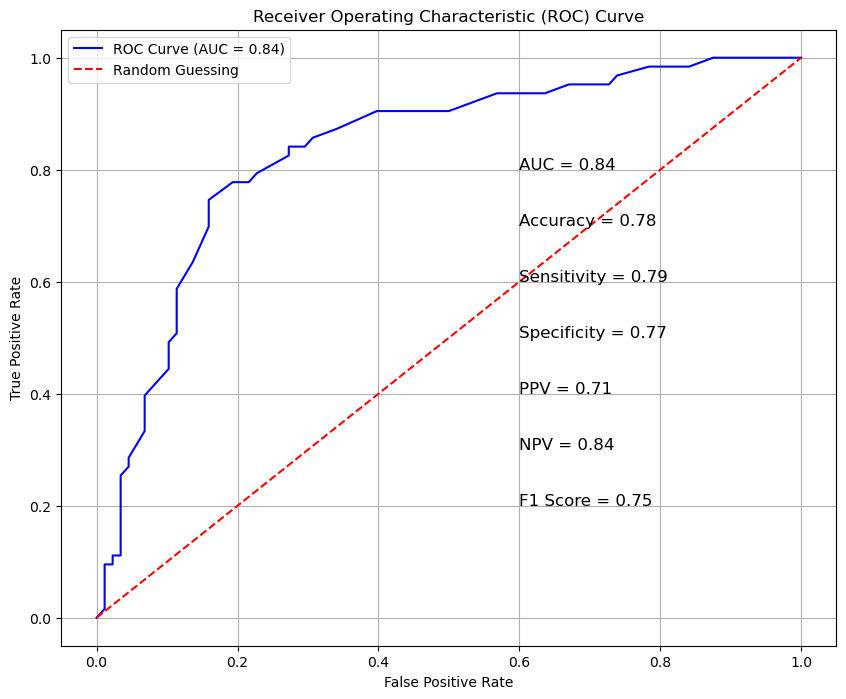

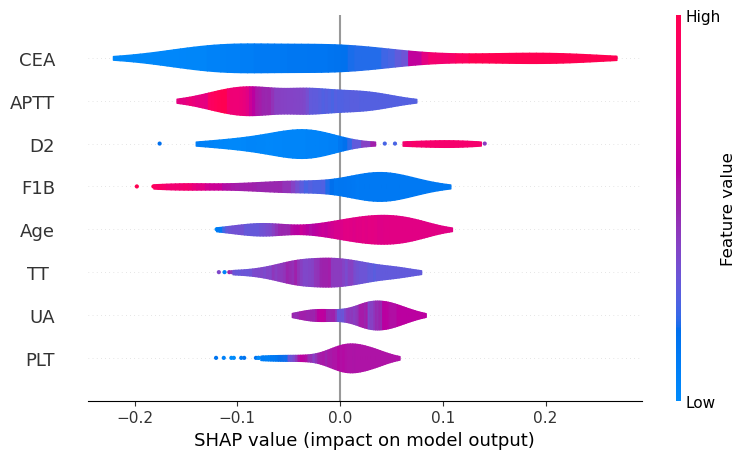

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, roc_curve, confusion_matrix
import shap
import numpy as np

# 读取数据集
data1 = pd.read_excel("训练集1.xlsx")
data2 = pd.read_excel("测试集1.xlsx")

# 提取特征和标签
X_train = data1.drop(columns=['cancer'])  # 训练集特征
y_train = data1['cancer']  # 训练集标签
X_test = data2.drop(columns=['cancer'])  # 测试集特征
y_test = data2['cancer']  # 测试集标签

# 创建随机森林模型
rf_model = RandomForestClassifier(random_state=42)

# 训练模型
rf_model.fit(X_train, y_train)

# 预测概率
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# 使用特定截断值重新分类
cutoff = 0.44  # 最佳截断值
y_pred = [1 if prob >= cutoff else 0 for prob in y_pred_prob]

# 计算混淆矩阵
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# 计算性能指标
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # 特异度
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # 阳性预测值
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # 阴性预测值
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

# 绘制 ROC 曲线
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.text(0.6, 0.8, f'AUC = {auc:.2f}', fontsize=12)
plt.text(0.6, 0.7, f'Accuracy = {accuracy:.2f}', fontsize=12)
plt.text(0.6, 0.6, f'Sensitivity = {sensitivity:.2f}', fontsize=12)
plt.text(0.6, 0.5, f'Specificity = {specificity:.2f}', fontsize=12)
plt.text(0.6, 0.4, f'PPV = {ppv:.2f}', fontsize=12)  # 添加PPV
plt.text(0.6, 0.3, f'NPV = {npv:.2f}', fontsize=12)  # 添加NPV
plt.text(0.6, 0.2, f'F1 Score = {f1:.2f}', fontsize=12)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

# 计算SHAP值
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# 绘制密度图
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=X_test.columns, plot_type="violin", title="SHAP value (impact on CRC)")

# 获取每个特征的 SHAP 值的平均影响
shap_values_mean = np.mean(shap_values, axis=0)
shap_values_mean = shap_values_mean[:, 0]  # 获取类别为1的 SHAP 值

# 创建包含测试集特征和预测概率的 DataFrame
data_with_proba = X_test.copy()  # 复制测试集特征
data_with_proba['Predicted Probability_RF'] = y_pred_prob  # 添加预测概率列

# 将DataFrame保存为Excel文件
data_with_proba.to_excel('测试集预测结果.xlsx', index=False)




In [5]:
import shap

# 使用训练好的解释器计算SHAP值
shap_values = explainer.shap_values(X_test)

# 确保 SHAP 值的形状正确
print("SHAP values shape:", shap_values.shape)

# 查看第三个样本的SHAP值（对于类别 0）
sample_index = 1  
shap.force_plot(explainer.expected_value[1], shap_values[sample_index][:, 1], X_test.iloc[sample_index], feature_names=X_test.columns)


SHAP values shape: (151, 8, 2)
